In [75]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import pickle
from astropy.table import Table,Column
import numpy as np
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 20

In [76]:
C =cosmology.Planck15

## First: generate matrix using labels to keep track

In [77]:
statesto = pd.Index(('BD1', 'RD1', 'RE1'))
statesfrom = pd.Index(('BD1', 'RD1'))
for i in range(2,6):
    statesto=statesto.append(pd.Index(('BD%s'%i,'RD%s'%i,'RE%s'%i)))
for i in range(2,4):
    statesfrom=statesfrom.append(pd.Index(('BD%s'%i,'RD%s'%i)))
statesfrom = statesfrom.append(pd.Index(('BD4','RD4','K')))
rate_labels = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom, data=np.chararray((15,9)))
for frm in statesfrom:
    for to in statesto:
        rate_labels['from '+frm]['to '+to] = '$r_{%s \rightarrow %s}$'%(frm,to)


In [78]:
def rate_matrix_labels(rates):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is a vector - m[0] = m1, m[3] = m4
    rate_mtrx = pd.DataFrame(index=np.linspace(0,2,3),columns=np.linspace(0,2,3),data=np.chararray((3,3)))
    
    rate_mtrx[0][0] = '-$a~sSFR(t)$' + rates['from BD4']['to RD4'] + ' -' +rates['from BD4']['to RE5']

    rate_mtrx[0][1] = rates['from BD4']['to RD4']
    
    rate_mtrx[1][1] = '-' + rates['from RD4']['to RE5']

    rate_mtrx[2][2] = '+/-' + rates['from K']['to RE4']
   
    return rate_mtrx


In [79]:
rm = rate_matrix_labels(rate_labels)
rm

,0.0,1.0,2.0
0,-$a~sSFR(t)$$r_{BD4 \rightarrow RD4}$ -$r_{BD4...,,
1,$r_{BD4 \rightarrow RD4}$,-$r_{RD4 \rightarrow RE5}$,
2,,,+/-$r_{K \rightarrow RE4}$


In [80]:
def alpha(a_s,M_star,m):
    alpha = (1+a_s) - m/M_star
    return alpha
def sSFR(t):
    sSFR = 2.5*(t/3.5)**(-2.2)
    return sSFR
def rate_matrix(rates,m,t):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    #m is one mass value
    rate_mtrx = pd.DataFrame(index=np.linspace(0,2,3),columns=np.linspace(0,2,3),data=np.zeros((3,3)))
    a_s = -1.4 
    M_star = 10.82

    rate_mtrx[0][0] =  - alpha(a_s,M_star,m)*sSFR(t) - rates['from BD4']['to RD4'] - rates['from BD4']['to RE5']
 
    rate_mtrx[0][1] = rates['from BD4']['to RD4']
    
    rate_mtrx[1][1] = - rates['from RD4']['to RE5']
    
    rate_mtrx[2][2] = rates['from K']['to RE4']
    
    return rate_mtrx

def modelrates(N, t, rates, rate_matrix_fn, m):
    rate_mtrx = rate_matrix_fn(rates,m,t)
    return np.dot(rate_mtrx, N)
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def plot_NF(F_RD,F_DR):
    colors = '#54235c'
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(12, 6))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, .4));
    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4));
    plt.tight_layout()

In [81]:
#load dictionary of data; N_RD, N_BD, N_RE, f_RID, f_DIR evolutions for each mass bin
with open('results.pickle', 'rb') as handle:
    results = pickle.load(handle)


In [82]:
#centers of bins where f_rid and f_dir are evaluated in the data
z_centers = results['z_centers']
#mass bins
m_centers = results['m_centers'][-1] #just highest mass bin
m = m_centers
#define times/redshifts to compute evolution in model
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value

model_z = [find_nearest(z,i) for i in z_centers[:]] #closest redshift in model to observed redshift values, excluding z=1 
#(z=1 is the input value, will always match model!)
model_z = model_z * 8 #2 for each fraction, 4 for each mass = 16 series 


rate_vector_labels = pd.Index(( ('BD4 to RD4'),
                               ('BD4 to RE5'),
                               ('RD4 to RE5'),
                               ('K to RE4')))

In [105]:
def model_fractions(rate_vector, m_centers):
    # Set rates per galaxy in Gyr^{-1} at fiducial redshift
    rates = pd.DataFrame(index='to ' + statesto, columns='from ' + statesfrom,data=np.zeros(shape=(15,9)))
    for i in range(4,5):
        rates['from BD{}'.format(i)]['to RD{}'.format(i)]=rate_vector['BD{} to RD{}'.format(i,i)]
        rates['from BD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['BD{} to RE{}'.format(i,i+1)]
        rates['from K']['to RE{}'.format(i)]=rate_vector['K to RE{}'.format(i)]
        rates['from RD{}'.format(i)]['to RE{}'.format(i+1)]=rate_vector['RD{} to RE{}'.format(i,i+1)]

    #set initial values
    states = pd.Index((('BD4'),('RD4'),('RE4')))
    #inital BD, RD, RE for masses 1-4 (z=1)
    N0=pd.Series(index=states)
    for i in range(0,1):
        N0['BD{}'.format(i+4)] = results['M={}'.format(m)]['N_BD'][len(z_centers)-1] #z=1 values
        N0['RD{}'.format(i+4)] = results['M={}'.format(m)]['N_RD'][len(z_centers)-1]
        N0['RE{}'.format(i+4)] = results['M={}'.format(m)]['N_RE'][len(z_centers)-1]    
    N0 /= N0.sum()  # normalise to unity
        
    #evolve numbers from z=1 to z=0.3
    N = odeint(modelrates, N0, t, args=(rates, rate_matrix, m_centers))
    N = pd.DataFrame(index=z, columns=states, data=N)
    N=N[::-1] #number evolution of BD,RD,RE
    
    F_RD = pd.DataFrame(index=N.index) #evolution of fractions
    F_DR = pd.DataFrame(index=N.index) #evolution of fractions

    for i in range(4,5):
        F_RD['$f_{R|D}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['BD{}'.format(i)])
    for i in range(4,5):
        F_DR['$f_{D|R}\_%s$'%i] = N['RD{}'.format(i)] / (N['RD{}'.format(i)]+N['RE{}'.format(i)])

    
    #compare results of fractions at 3 redshifts, for 2 fractions, for all 4 masses, compute chi-squared:
    chi2 = 0

    for i,zc in enumerate(z_centers[:-1]): 
        obs_f_rid = results['M={}'.format(m)]['f_RID'][i]
        obs_f_dir = results['M={}'.format(m)]['f_DIR'][i]
        obs_f_rid_err = results['M={}'.format(m)]['f_RID_err'][i]
        obs_f_dir_err = results['M={}'.format(m)]['f_DIR_err'][i]

        idx = find_nearest(z,zc) #find closest redshift to zc in model
        model_f_rid = F_RD['$f_{R|D}\_%s$'%(4)][idx]
        model_f_dir = F_DR['$f_{D|R}\_%s$'%(4)][idx]
    
        chi2 += ((obs_f_rid - model_f_rid)/obs_f_rid_err)**2
        chi2 += ((obs_f_dir - model_f_dir)/obs_f_dir_err)**2

    #all done! return chi square value for these rates
    return F_RD, F_DR, chi2
    #return chi2

In [84]:
def plot_NF(F_RD,F_DR):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 30
    colors = '#54235c'
    fig, (axrd, axdr) = plt.subplots(1, 2, figsize=(18, 8))
    F_RD.plot(ax=axrd,colors=colors,lw=2)
    axrd.legend(loc=4,fontsize=20)
    
    #high mass 
    y=results['M={}'.format(m)]['f_RID']
    yerr = results['M={}'.format(m)]['f_RID_err']
    lo = [a-b for a,b in zip(y,yerr)]
    hi = [a+b for a,b in zip(y,yerr)]

    axrd.scatter(model_z[0:4],y,color='#54235c',marker='*',s=300)
    axrd.fill_between(model_z[0:4],lo,hi,alpha=.03)

    axrd.set(xlabel='$z$', ylabel='$f_{R|D}(z)$', ylim=(0, .4),xlim=(.29,1.1));

    F_DR.plot(ax=axdr,colors=colors,lw=2)
    axdr.legend(loc=4,fontsize=20)

    #high mass 
    y=results['M={}'.format(m)]['f_DIR']
    yerr = results['M={}'.format(m)]['f_DIR_err']
    lo = [a-b for a,b in zip(y,yerr)]
    hi = [a+b for a,b in zip(y,yerr)]

    axdr.scatter(model_z[0:4],y,color='#54235c',marker='*',s=300)
    axdr.fill_between(model_z[0:4],lo,hi,alpha=.03)
    axdr.set(xlabel='$z$')
    axdr.set(ylabel='$f_{D|R}(z)$', ylim=(0, 0.4),xlim=(.29,1.1));
    plt.tight_layout()

In [85]:
#define rate labels
rate_vector_labels = pd.Index(( ('BD4 to RD4'),
                                ('BD4 to RE5'),
                                ('RD4 to RE5'),
                                ('K to RE4')))

In [86]:
def rate_list(n=10., w=.1):
    #d = bd4 -> rd4
    #h = bd4 -> re5
    #l = rd4 -> re5
    #q = K -> re4
    
    #max rate = +/- 0.1
    #n = number of steps for each rate
    m1=.041
    m2 = .0825
    rate_data = [[round(d*m1+.005,3),
                  round(h*m1+.005,3),
                  round(l*m1+.005,3),
                  round(q*m2-.99,3)] 
                  for d in range(0,25)
                  for h in range(0,25)
                  for l in range(0,25)
                  for q in range(0,25)
             ]
    return rate_data

In [ ]:
r = np.linspace(-.99,.99,25)
m2=r[1]-r[0]
ratedata = [round(i*m2+r[0],3) for i in range(0,25)]
ratedata,m2

(array([ 15625.,  15625.,  15625.,  15625.,  15625.,  15625.,  15625.,
         15625.,  15625.,  15625.,  15625.,  15625.,  15625.,  15625.,
         15625.,  15625.,  15625.,  15625.,  15625.,  15625.,  15625.,
         15625.,  15625.,  15625.,  15625.]),
 array([-0.99  , -0.9108, -0.8316, -0.7524, -0.6732, -0.594 , -0.5148,
        -0.4356, -0.3564, -0.2772, -0.198 , -0.1188, -0.0396,  0.0396,
         0.1188,  0.198 ,  0.2772,  0.3564,  0.4356,  0.5148,  0.594 ,
         0.6732,  0.7524,  0.8316,  0.9108,  0.99  ]),
 <a list of 25 Patch objects>)

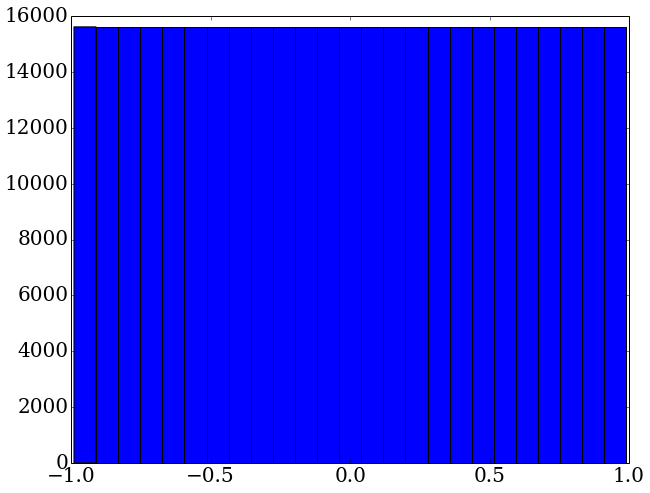

In [87]:
#sanity checks
rate_data = rate_list()

this_rate = [val[3] for val in rate_data]
plt.hist(this_rate,bins=25)

In [88]:
#generate a bunch of combinations of rates, 2 each, maximum rate of 0.1
#rate_data = rate_list()
print 'number of combinations: %s'%len(rate_data)

number of combinations: 390625


In [62]:
#create table to save results
c0 = Column(np.zeros(1),name='chi2') 
c2 = Column(np.zeros(1), name = 'BD4 to RD4')
c4 = Column(np.zeros(1), name = 'BD4 to RE5')
c6 = Column(np.zeros(1), name = 'RD4 to RE5')
c8 = Column(np.zeros(1), name = 'K to RE4')

chi2_table_1d_mass4 = Table()  
chi2_table_1d_mass4.add_columns([c0,c2,c4,c6,c8])


In [89]:
#or: load table
chi2_table_1d_mass4 = Table.read('chi2_table_1d_mass4.fits')
#chi2_table.remove_row(0)
len(chi2_table_1d_mass4)

390101

In [90]:
chi2_table_1d_mass4[0]

chi2,BD4 to RD4,BD4 to RE5,RD4 to RE5,K to RE4
float64,float64,float64,float64,float64
1315.90371742,0.005,0.005,0.005,-0.99


In [99]:
fname = 'chi2_table_1d_mass4.fits'

import datetime
#test 30,000 rate combos to start 
for i,vector in enumerate(rate_data[390101:]):
    rate_vector = pd.Series(index=rate_vector_labels,data=vector)
    chi2val = model_fractions(rate_vector,m_centers)
    chi2_table_1d_mass4.add_row([chi2val]+vector)
    if i % 1000 ==0:
        print i, chi2val, datetime.datetime.now().strftime('%H:%M:%S.%f')
    if i % 10000 ==0:
        chi2_table_1d_mass4.write(fname,format='fits',overwrite=True)

0 2822.64425533 10:12:45.624813


In [101]:
#chi2_table_1d_mass4.remove_row(0)
chi2_table_1d_mass4.write(fname,format='fits',overwrite=True) #once more for good measure
len(chi2_table_1d_mass4)

390625

In [102]:
find_nearest_idx(chi2_table_1d_mass4['chi2'],np.min(chi2_table_1d_mass4['chi2']))

142491

In [93]:
#plot a few of the best values
def plot_best_values(rank):
    #rank = 0 for lowest chi2, 1 for second lowest, etc. 
    rate_list = []
    for val in chi2_table_1d_mass4[rank]:
        rate_list.append(val)
    rate_list = rate_list[1:]
    rate_vector = pd.Series(index=rate_vector_labels,data=rate_list) #rate combo with best chi2
    F_RD,F_DR,chi2val = model_fractions(rate_vector,m)
    plot_NF(F_RD,F_DR)

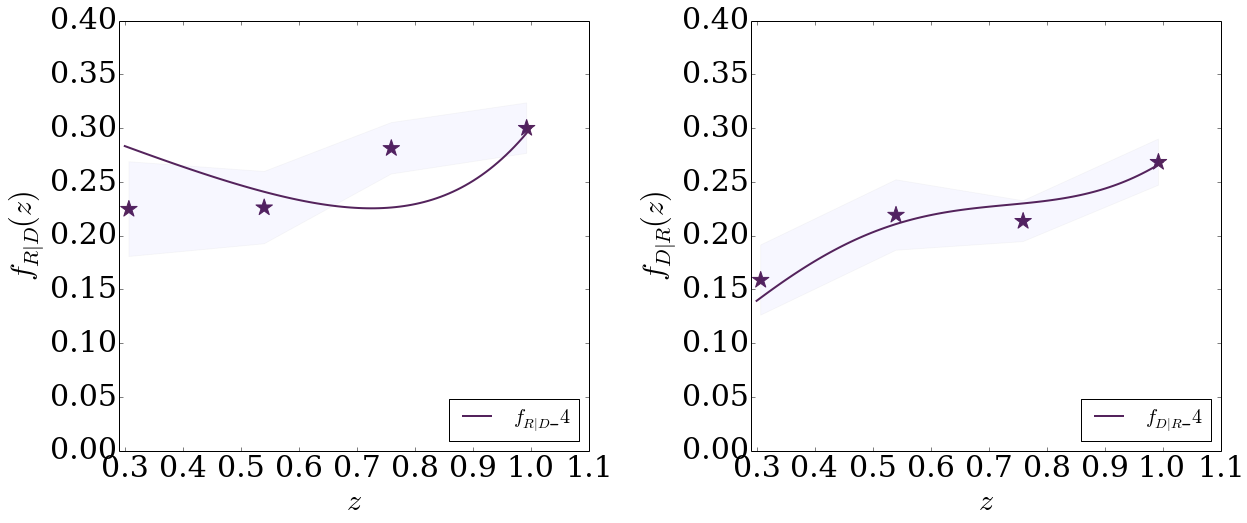

In [122]:
plot_best_values(3)

In [96]:
chi2_table_1d_mass4[142491]

chi2,BD4 to RD4,BD4 to RE5,RD4 to RE5,K to RE4
float64,float64,float64,float64,float64
8.15453055991,0.374,0.087,0.989,0.33


In [103]:
chi2_table_1d_mass4.sort('chi2')

In [123]:
for i in range(0,10):
    print chi2_table_1d_mass4[i]

     chi2     BD4 to RD4 BD4 to RE5 RD4 to RE5 K to RE4
------------- ---------- ---------- ---------- --------
8.15453055991      0.374      0.087      0.989     0.33
     chi2     BD4 to RD4 BD4 to RE5 RD4 to RE5 K to RE4
------------- ---------- ---------- ---------- --------
8.15869447196      0.374      0.005      0.907    0.413
     chi2     BD4 to RD4 BD4 to RE5 RD4 to RE5 K to RE4
------------- ---------- ---------- ---------- --------
8.25604460769      0.333       0.21      0.948    0.248
     chi2     BD4 to RD4 BD4 to RE5 RD4 to RE5 K to RE4
------------- ---------- ---------- ---------- --------
8.25604521125      0.333      0.128      0.866     0.33
     chi2     BD4 to RD4 BD4 to RE5 RD4 to RE5 K to RE4
------------- ---------- ---------- ---------- --------
8.26121683649      0.333      0.046      0.784    0.413
     chi2     BD4 to RD4 BD4 to RE5 RD4 to RE5 K to RE4
------------- ---------- ---------- ---------- --------
8.33570564533      0.374      0.005      0.866  